In [1]:
# Instalacja pakietu minisom
!pip install MiniSom

  Preparing metadata (setup.py) ... done
  Created wheel for MiniSom: filename=MiniSom-2.3.3-py3-none-any.whl size=11706 sha256=d21dc5f4233a0fc0c7700837d0875a7d4de5f91b787c4772fa6ebee6357efc0e
  Stored in directory: /root/.cache/pip/wheels/c8/29/ba/ee521d9a6af783a1e1efb1831fe4afdf526613849b3f58175b
Successfully built MiniSom


In [4]:
!pip install keras

In [6]:
# Importowanie bibliotek

import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
import os
from google.colab import drive
import random
import seaborn as sns
from sklearn.decomposition import PCA

In [7]:
# Podłączenie Google Drive
drive.mount('/content/drive')

# Ścieżki do folderów z danymi
base_dir = '/content/drive/MyDrive/Pneumonia'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')
train_normal_dir = os.path.join(train_dir, 'NORMAL')
val_pneumonia_dir = os.path.join(val_dir, 'PNEUMONIA')
val_normal_dir = os.path.join(val_dir, 'NORMAL')
test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')
test_normal_dir = os.path.join(test_dir, 'NORMAL')

Mounted at /content/drive


In [8]:
# Funkcja licząca pliki w katalogu
def count_files_in_directory(directory):
    return len(os.listdir(directory))

print(f"Number of pneumonia images in training set: {count_files_in_directory(train_pneumonia_dir)}")
print(f"Number of normal images in training set: {count_files_in_directory(train_normal_dir)}")
print(f"Number of pneumonia images in validation set: {count_files_in_directory(val_pneumonia_dir)}")
print(f"Number of normal images in validation set: {count_files_in_directory(val_normal_dir)}")
print(f"Number of pneumonia images in test set: {count_files_in_directory(test_pneumonia_dir)}")
print(f"Number of normal images in test set: {count_files_in_directory(test_normal_dir)}")

Number of pneumonia images in training set: 3875
Number of normal images in training set: 1341
Number of pneumonia images in validation set: 8
Number of normal images in validation set: 8
Number of pneumonia images in test set: 226
Number of normal images in test set: 234


In [9]:
# Funkcja ładująca zdjęcia z folderu
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = load_img(img_path, target_size=(224, 224))
        img = img_to_array(img)
        images.append(img)
        labels.append(label)
    print(f"Loaded {len(images)} images from {folder}")
    return images, labels

In [10]:
# Ładowanie danych
def load_data():
    train_pneumonia_images, train_pneumonia_labels = load_images_from_folder(train_pneumonia_dir, 1)
    train_normal_images, train_normal_labels = load_images_from_folder(train_normal_dir, 0)
    val_pneumonia_images, val_pneumonia_labels = load_images_from_folder(val_pneumonia_dir, 1)
    val_normal_images, val_normal_labels = load_images_from_folder(val_normal_dir, 0)
    test_pneumonia_images, test_pneumonia_labels = load_images_from_folder(test_pneumonia_dir, 1)
    test_normal_images, test_normal_labels = load_images_from_folder(test_normal_dir, 0)

    # Balansowanie danych uczących
    num_samples = 1341
    train_pneumonia_images = random.sample(train_pneumonia_images, num_samples)
    train_pneumonia_labels = [1] * num_samples
    train_normal_images = random.sample(train_normal_images, num_samples)
    train_normal_labels = [0] * num_samples

    X_train = np.array(train_pneumonia_images + train_normal_images)
    y_train = np.array(train_pneumonia_labels + train_normal_labels)
    X_val = np.array(val_pneumonia_images + val_normal_images)
    y_val = np.array(val_pneumonia_labels + val_normal_labels)
    X_test = np.array(test_pneumonia_images + test_normal_images)
    y_test = np.array(test_pneumonia_labels + test_normal_labels)

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_data()

print(f"Dataset structure:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Number of pneumonia images in training set after balancing: {np.sum(y_train == 1)}")
print(f"Number of normal images in training set after balancing: {np.sum(y_train == 0)}")
print(f"Number of pneumonia images in validation set: {np.sum(y_val == 1)}")
print(f"Number of normal images in validation set: {np.sum(y_val == 0)}")
print(f"Number of pneumonia images in test set: {np.sum(y_test == 1)}")
print(f"Number of normal images in test set: {np.sum(y_test == 0)}")

Loaded 3875 images from /content/drive/MyDrive/Pneumonia/train/PNEUMONIA
Loaded 1341 images from /content/drive/MyDrive/Pneumonia/train/NORMAL
Loaded 8 images from /content/drive/MyDrive/Pneumonia/val/PNEUMONIA
Loaded 8 images from /content/drive/MyDrive/Pneumonia/val/NORMAL
Loaded 226 images from /content/drive/MyDrive/Pneumonia/test/PNEUMONIA
Loaded 234 images from /content/drive/MyDrive/Pneumonia/test/NORMAL
Dataset structure:
X_train shape: (2682, 224, 224, 3), y_train shape: (2682,)
X_val shape: (16, 224, 224, 3), y_val shape: (16,)
X_test shape: (460, 224, 224, 3), y_test shape: (460,)
Number of pneumonia images in training set after balancing: 1341
Number of normal images in training set after balancing: 1341
Number of pneumonia images in validation set: 8
Number of normal images in validation set: 8
Number of pneumonia images in test set: 226
Number of normal images in test set: 234


In [11]:
# Przekształcenie zdjęć przy wykorzystaniu sieci konwolucyjnej VGG-16
def preprocess_images(X):
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Model(inputs=vgg_model.input, outputs=vgg_model.output)

    X_preprocessed = preprocess_input(X)
    features = model.predict(X_preprocessed)
    features_flattened = features.reshape(features.shape[0], -1)
    return features_flattened

X_train_features = preprocess_images(X_train)
X_val_features = preprocess_images(X_val)
X_test_features = preprocess_images(X_test)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 1750s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 295s 20s/step


In [12]:
# Trening  SOM

som = MiniSom(x=10, y=10, input_len=X_train_features.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(X_train_features)
som.train_random(X_train_features, 200)


In [13]:
# Przekształcanie danych przy użyciu  SOM
X_train_som = np.array([som.winner(x) for x in X_train_features])
X_val_som = np.array([som.winner(x) for x in X_val_features])
X_test_som = np.array([som.winner(x) for x in X_test_features])

In [14]:
# Trening klasyfikatora SVM
clf = SVC()
# Predykcja na zbiorze testowym
clf.fit(X_train_som, y_train)

SVC()

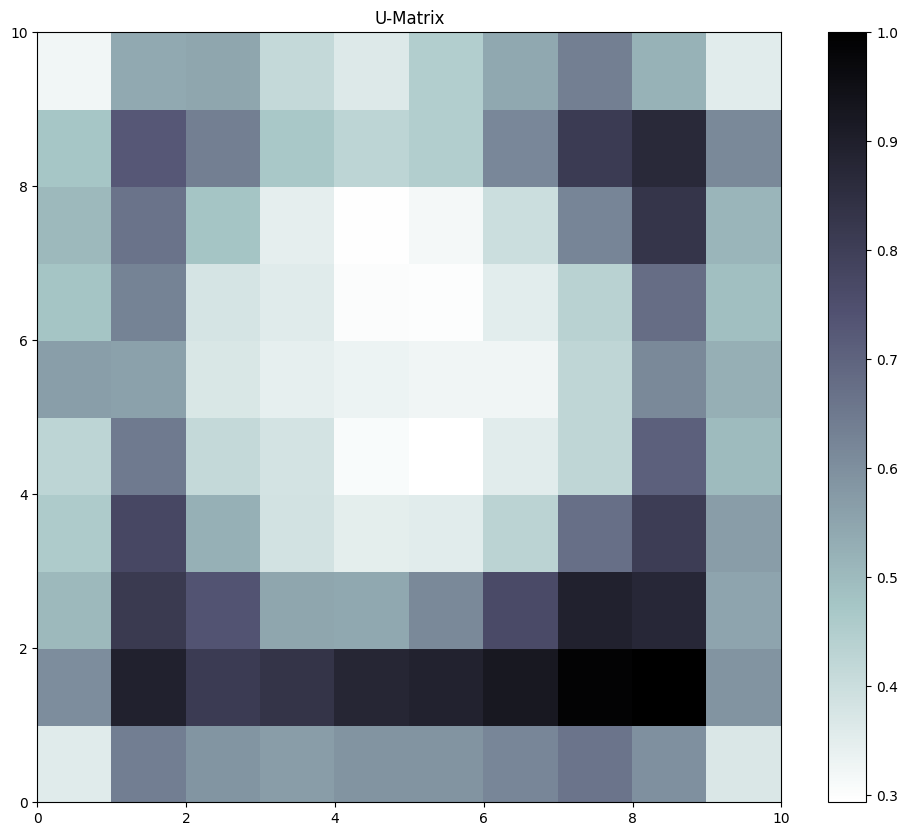

In [15]:
# Wizualizacja SOM używając U-Matrix
def plot_umatrix(som):
    u_matrix = som.distance_map().T
    plt.figure(figsize=(12, 10))
    plt.pcolor(u_matrix, cmap='bone_r')
    plt.colorbar()
    plt.title('U-Matrix')
    plt.show()
plot_umatrix(som)

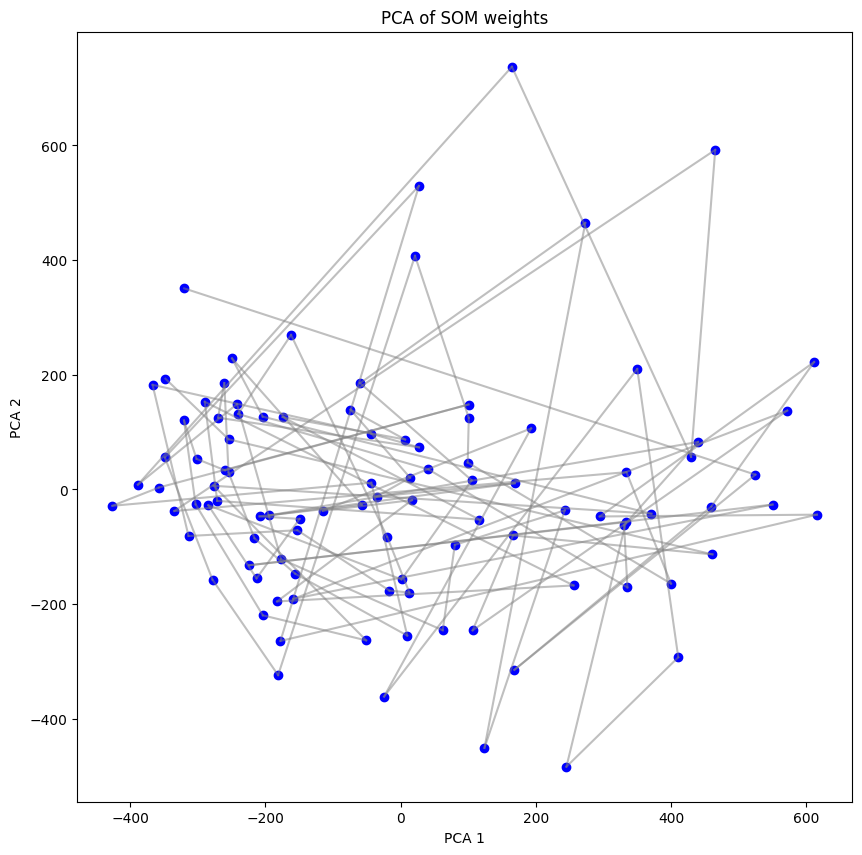

In [16]:
# Wizualizacja SOM poprzez PCA
def plot_pca_som(som, X_train_features):
    weights = som.get_weights().reshape(-1, X_train_features.shape[1])
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(weights)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', marker='o')
    ax.set_title('PCA of SOM weights')
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')

    for i in range(len(pca_result) - 1):
        ax.plot([pca_result[i, 0], pca_result[i + 1, 0]], [pca_result[i, 1], pca_result[i + 1, 1]], color='gray', alpha=0.5)

    plt.show()

plot_pca_som(som, X_train_features)

In [17]:
# Predykcja na zbiorze testowym
y_pred = clf.predict(X_test_som)

Classification report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       234
           1       0.79      0.84      0.81       226

    accuracy                           0.81       460
   macro avg       0.81      0.81      0.81       460
weighted avg       0.81      0.81      0.81       460

Confusion matrix:


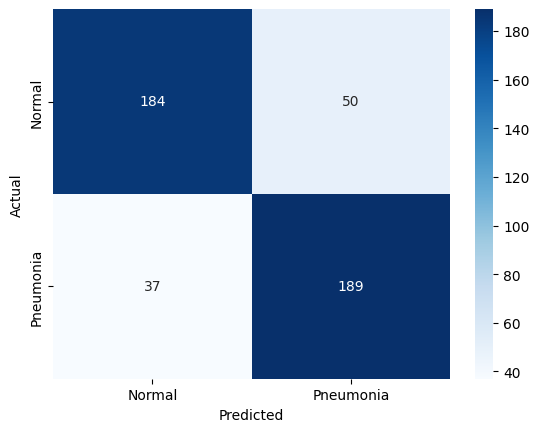

In [18]:
# Ewaluacja modelu na zbiorze testowym
print("Classification report:")
print(classification_report(y_test, y_pred))

print("Confusion matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

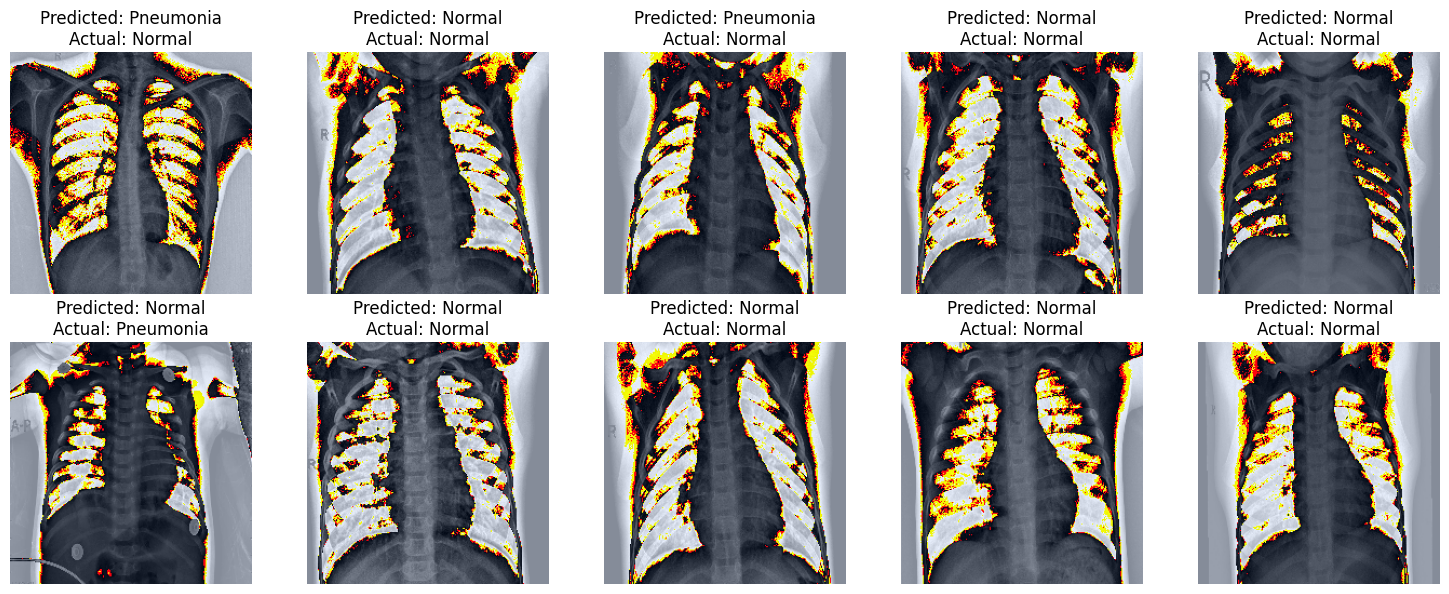

In [19]:
# Wizualizacja predykcji na losowych danych testowych
def plot_test_predictions(X_test, y_test, y_pred, indices):
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    axs = axs.flatten()
    classes = ['Normal', 'Pneumonia']
    for i, idx in enumerate(indices):
        axs[i].imshow(X_test[idx].astype(np.uint8))
        predicted = y_pred[idx]
        actual = y_test[idx]
        axs[i].set_title(f'Predicted: {classes[predicted]}\nActual: {classes[actual]}')
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

random_test_indices = random.sample(range(len(X_test)), 10)
plot_test_predictions(X_test, y_test, y_pred, random_test_indices)




Validation set classification report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16

Validation set confusion matrix:


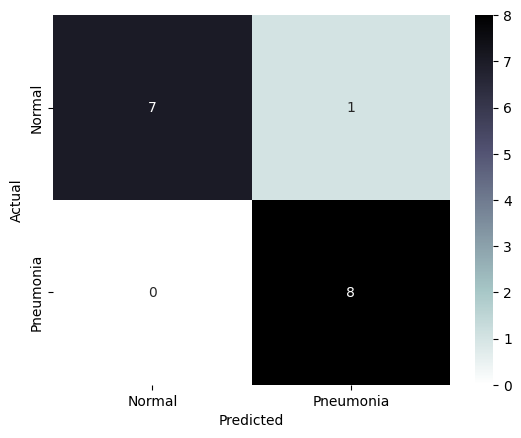

In [20]:
# Predykcja na zbiorze walidacyjnym
y_val_pred = clf.predict(X_val_som)


# Ewaluacja modelu na zbiorze walidacyjnym
print("Validation set classification report:")
print(classification_report(y_val, y_val_pred))

print("Validation set confusion matrix:")
val_conf_matrix = confusion_matrix(y_val, y_val_pred)
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='bone_r', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

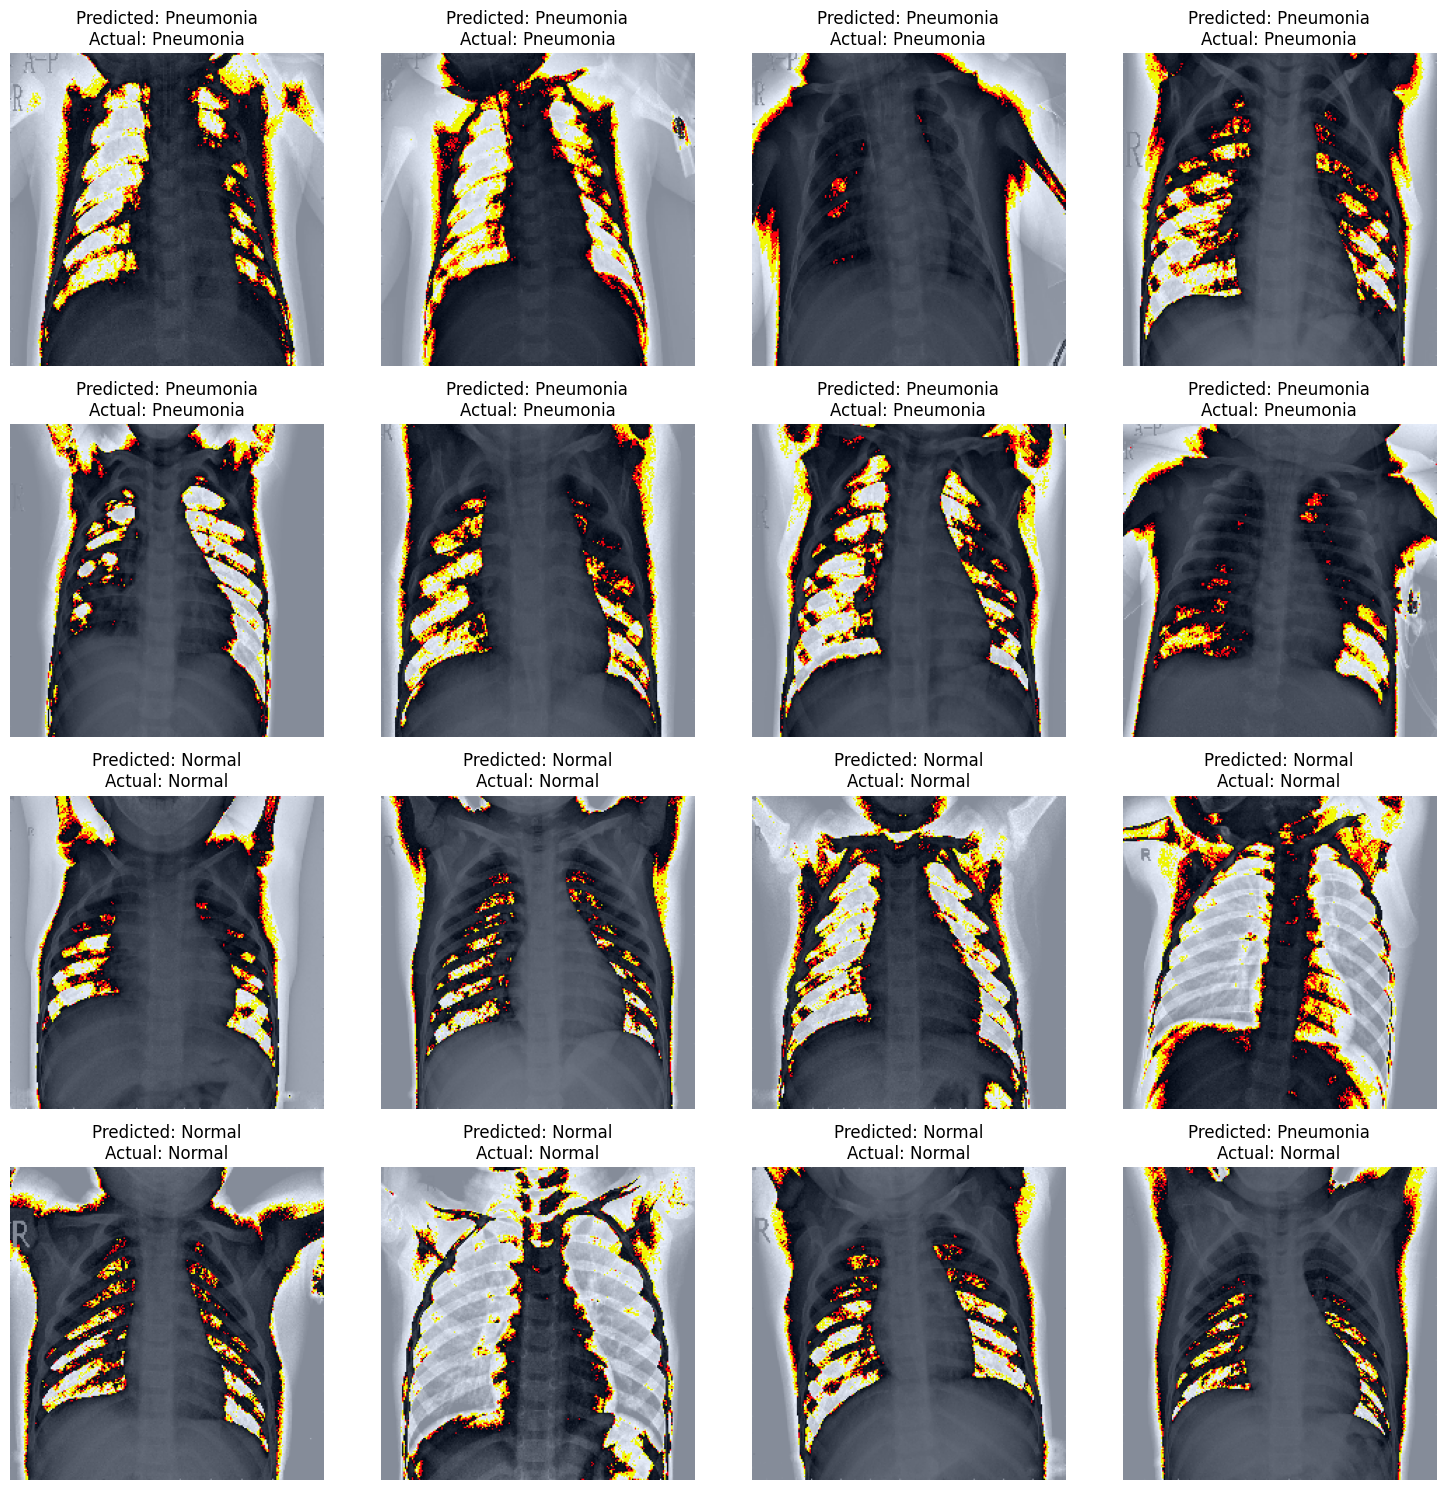

In [21]:

# Wizualizacja predykcji na zbiorze walidacyjnym w siatce 4x4
def plot_val_predictions(X_val, y_val, y_val_pred):
    fig, axs = plt.subplots(4, 4, figsize=(15, 15))
    axs = axs.flatten()
    classes = ['Normal', 'Pneumonia']
    for i in range(len(X_val)):
        axs[i].imshow(X_val[i].astype(np.uint8))
        predicted = y_val_pred[i]
        actual = y_val[i]
        axs[i].set_title(f'Predicted: {classes[predicted]}\nActual: {classes[actual]}')
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

plot_val_predictions(X_val, y_val, y_val_pred)
